# Computer Vision - Assignment 1 - Image Filtering

### Student's name: Anna Ivanchenko





---



## Support functions and connection to Google Drive


In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [ ]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [ ]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Apple',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

In [ ]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Apples',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Exercise 1: mask discretization and Gaussian filtering** (4 points).

In this exercise we will learn to discretize convolution masks and apply them to images using OpenCV functions. We also seek to do it in an efficient way, and that is why, in all this assignment, the use of 1D (separable) convolutions is required.




## A) (1.5 points)

**The Task:** Compute the 1D discrete masks of the Gaussian function, and both its first and second derivatives (normalized). Consider that the input to such a 1D mask creation function can be both a possible sigma or a possible mask size. Use the following sigma values ($\{1, 2.5, 5\}$) and the following mask size values ($\{5, 9, 15\}$), and display the profile (that is, the silhouette of the masks as 1D functions) to verify that the created masks are correct.

**The Solution:** In this subsection, I explain how I calculated the discrete 1D masks of the Gaussian function, its 1st and 2nd derivatives amd reasoning behind each step.

In order to work with Gaussian and Laplacian pyramids, it is nessesary to create 2D Gaussian. To do so, we can use Separability of the Gaussian: the 2D Gaussian can me expressed as the product of two function of x and y, that are identical 1D Gaussian.

### **Gaussian Function**

The Gaussian function is defined as:

$$\text{GaussFunc}(x, \sigma) = c \cdot e^{-\frac{x^2}{2\sigma^2}}$$

- `c`: A constant (which we can ignore).
- `x`: The point at which we evaluate the function.
- `sigma`: The standard deviation of the mean, “scale” of the Gaussian kernel, controls the amount of smoothing.

Gaussian removes "high-frequency" components from the image, working as a low-pass filter. As a consequence, image becomes smoother.

### **First Derivative of Gaussian**

The first derivative of the Gaussian function with respect to x:

$$\text{GaussDeriv1Func}(x, \sigma) = \frac{d}{dx} \left(c \cdot e^{-\frac{x^2}{2\sigma^2}}\right) = -\frac{x}{\sigma^2} \cdot \text{GaussFunc}(x, \sigma)$$

We want to find edges on the image. To do so, we can use following:
1. We know that the 1st derivative of a 2D Gaussian is separable. The partial derivative of a Gaussian is composed of the derivative in one
direction and the Gaussian in the other.
2. We are interested in implicitly
smoothing the signal to avoid magnifying the noise. So, we smooth
in one direction and differentiate in the other.
3. Mathematically, a separable kernel function leads to a separable
convolution.


### **Second Derivative of Gaussian**

The second derivative of the Gaussian function:

$$\text{GaussDeriv2Func}(x, \sigma) = \frac{d^2}{dx^2} \left(c \cdot e^{-\frac{x^2}{2\sigma^2}}\right) = \frac{x^2 - \sigma^2}{\sigma^4} \cdot \text{GaussFunc}(x, \sigma)$$

Second derivatives allow us to locate the edge more precisely.

### **1D Gaussian Mask**

The `gaussianMask1D` function generates a 1D discrete Gaussian mask based on either the specified `sigma` or the desired `sizeMask`.

- We know that almost all values in Gaussian lie within three standard deviations of the mean. Therefore, by default, we use `3 sigma`.
- Then, to choose k-value, we can follow this rule: $$k \ge 3 \cdot \sigma$$
- The mask is centered around zero and spans from `-k` to `k`, so here `k` is determined by `3*sigma`.
- To find the relation between `sigma` and `sizeMask`, we can solve following equations:
$$T = 2 \cdot k + 1$$
$$\frac{T-1}{2} = k$$
$$\frac{T-1}{2} = 3 \cdot \sigma$$
$$T=2 \cdot [3 \cdot \sigma] + 1$$
- Thus, when `sigma` is given, the function calculates the mask size `sizeMask` as: $$\text{sizeMask} = 2 \cdot [3 \cdot \sigma] + 1$$
- When the `sizeMask` is provided, it calculates `sigma` from the mask size: $$\sigma = \frac{T - 1}{6}$$

To correctly centered the function, I used np.arrange from -k to k, where k = 3*sigma, which gives us a range [-k, -k+1, ..., 0, ..., k-1, k].

### **Normalization of 1D Gaussian Masks**

The normalization of the 1D Gaussian masks depends the type of kernel, if it's smoothing or differentiating. In this function in depends on the `order` parameter:

1. **Gaussian Mask = Smoothing (`order = 0`)**:
    - For Gaussian smoothing, the mask is normalized by dividing each value by the sum of all mask values.

2. **First Derivative in X = Differentiating (`order = 1`)**:
    - When calculating the first derivative in the X direction, we compute the derivative of the Gaussian function.
    - To recover the original amplitude, we scale the derivative by multiplying it by `sigma`.

3. **Second Derivative in X = = Differentiating (`order = 2`)**:
    - For the second derivative in the X direction, we calculate the second derivative of the Gaussian function.
    - Similar to the first derivative, to avoid shrinking and recover response, we scale the second derivative by `sigma^2`.












In [ ]:
def GaussFunc(x,sigma):
    return np.exp(-(x**2/(2*sigma**2))) # I computed 1D  Gaussian function, but ignored constant c

def GaussDeriv1Func(x,sigma):
    return (-x/(sigma**2))*GaussFunc(x, sigma) # Computed First Derivative of 1D Gaussian function from previous step

def GaussDeriv2Func(x,sigma):
    return ((x**2-sigma**2)/(sigma**4))*GaussFunc(x, sigma) # Computed Second Derivative of 1D Gaussian function (took one more derivative from the first derivative)

def gaussianMask1D(sigma=0, sizeMask=0, order=0): # Function to compute Gaussian Mask, 1st and 2nd derivative
    if sizeMask==0: # Calculate sizeMask for the case when sigma is provided
        sizeMask = int(2*(3*sigma)+1) # (T-1)/2=3*sigma -> T=2*(3*sigma)+1, where T is a sizeMask
    elif sigma==0: # Calculate sigma for the case when sizeMask is provided
        sigma = (sizeMask-1)/6 # As (T-1)/2=3*sigma from the slide 23

    # Created a 1D mask centered at 0.
    # min(k) >= 3*sigma -> k = 3*sigma: k is varies from -3*sigma to 3*sigma
    k = np.floor(3*sigma)
    x = np.arange(-k, k+1) # added +1, as the the second border is not included in this function: numpy.arange([start, ]stop, [step, ]dtype=None, *, like=None)

    # Calculate Guassian mask, 1st and 2nd deriv depend on the order
    if order==0:
        mask=GaussFunc(x, sigma)  # Calculated Gaussian mask with previously created function
        # Normalized mask: Gaussian kernel is smoothing, so we need to divide by the sum
        mask /= np.sum(mask)
    elif order==1:
        mask=GaussDeriv1Func(x, sigma)  # Calculated first derivative mask with previously created function
        # Normalized mask: 1st Derivative kernel is Differentiating, so we need to multuply by sigma (this way we recover the amplitude)
        mask = mask*sigma
    elif order==2:
        mask=GaussDeriv2Func(x, sigma)  # Calculated second derivative mask with previously created function
        # Normalized mask: 2nd Derivative kernel is Differentiating, so we need to multuply by sigma**2 (in order to recover the response and avoid shrinking)
        mask = mask*sigma**2

    return mask, x

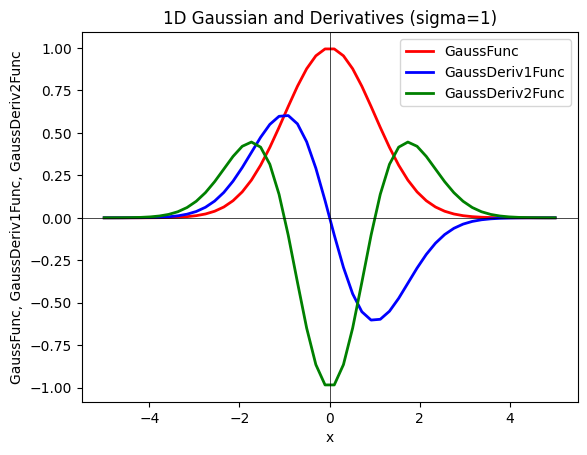

In [ ]:
# With the following figure we check that the implemented Gaussian functions are correct
plt.figure()
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend()
sizeMask = 5

For this part of the task, I'm plotting Gaussian for two cases:
1. When sigma is given. Then, as it was developed in the function, I calculate `sizeMask` with the formula:
$$\text{sizeMask} = 2 [3 \cdot \sigma] + 1$$
2. When `sizeMask` is given. Then the `sigma` is calculated as:
$$\sigma = \frac{T - 1}{6}$$

Here, I use previously created functions to calculate 1D Gaussian, 1st and 2nd derivative with the `sigma` values ({1,2.5,5}) and the following mask size values ({5,9,15}). Then I displayed the silhouette of the masks as 1D functions, to verify that the created masks are correct.

WE FIRST SET THE MASK SIZE


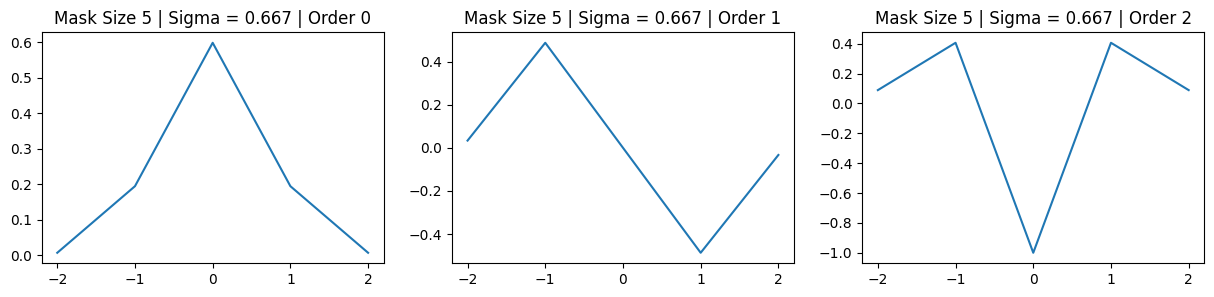

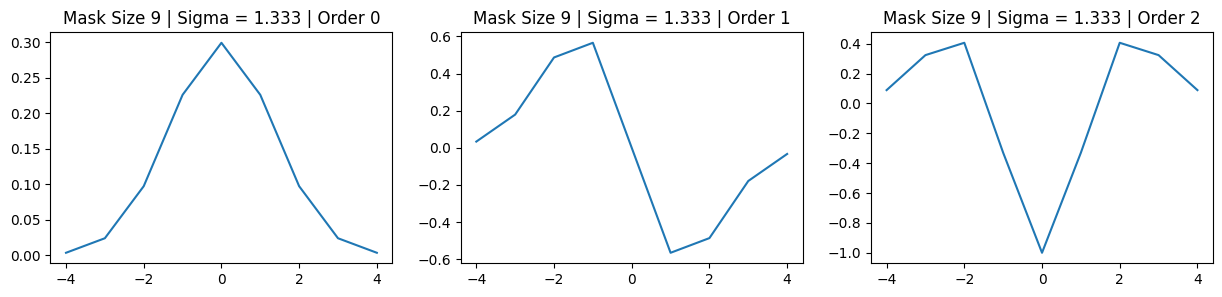

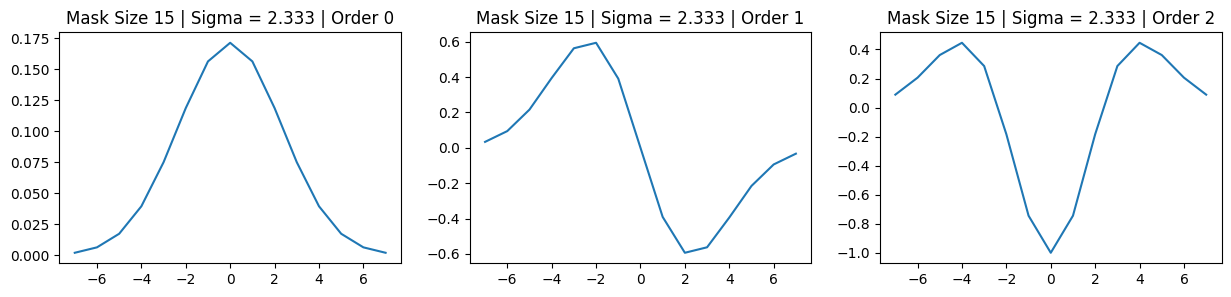

WE NOW SET SIGMA


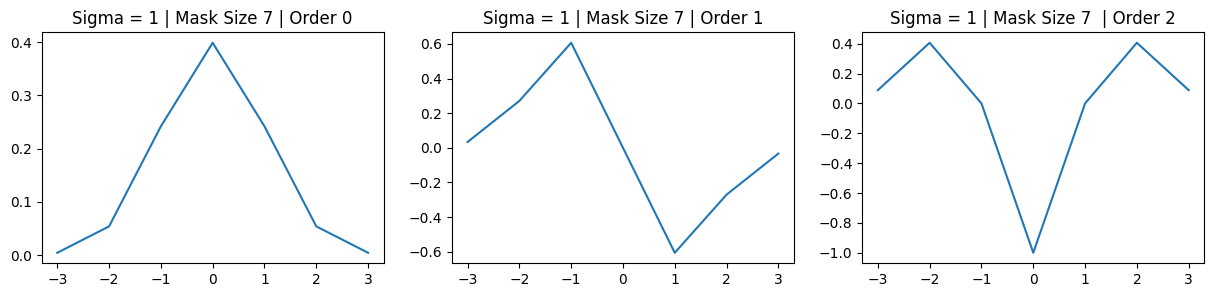

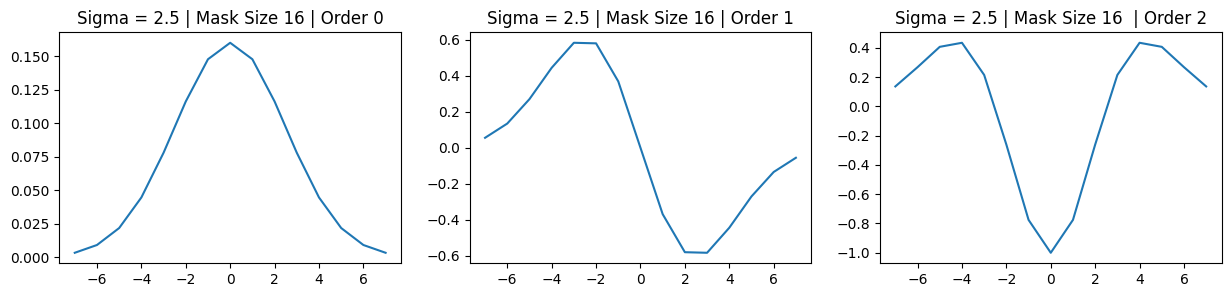

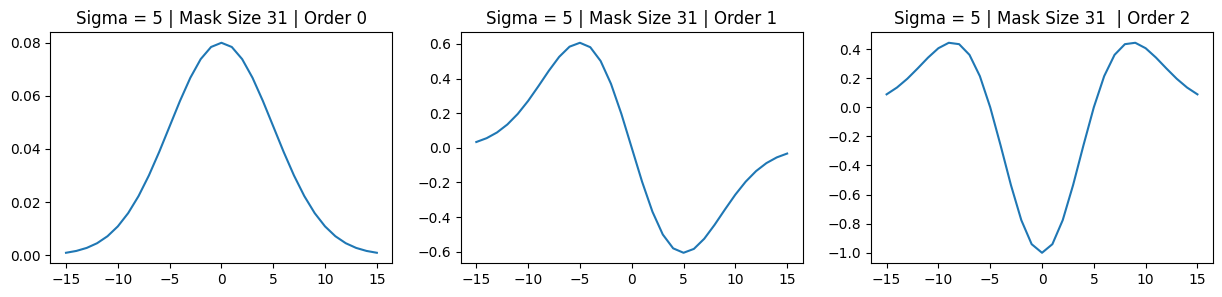

In [ ]:
sigma_values = [1, 2.5, 5]
size_masks = [5, 9, 15]

plt.rcParams["figure.figsize"] = (15,3) # To adjust height and width (axis)
print('WE FIRST SET THE MASK SIZE')
for sizeMask in size_masks:
  mask_gauss, x = gaussianMask1D(sigma=0, sizeMask=sizeMask, order=0) # I applied function to calculate 1D Gaussian mask
  mask_deriv1, x = gaussianMask1D(sigma=0, sizeMask=sizeMask, order=1) # Applied function to calculate 1st Derivative
  mask_deriv2, x = gaussianMask1D(sigma=0, sizeMask=sizeMask, order=2) # Applied function to calculate 2nd Derivative

  sigma = np.round(((sizeMask-1)/6), 3)

  # Plotting results of Gaussian Mask
  plt.figure()
  plt.subplot(1, 3, 1)
  plt.plot(x, mask_gauss)
  plt.title(f"Mask Size {sizeMask} | Sigma = {sigma} | Order 0")

  # Plotting results of 1st Detivative Mask
  plt.subplot(1, 3, 2)
  plt.plot(x, mask_deriv1)
  plt.title(f"Mask Size {sizeMask} | Sigma = {sigma} | Order 1")

  # Plotting results of 2nd Detivative Mask
  plt.subplot(1, 3, 3)
  plt.plot(x, mask_deriv2)
  plt.title(f"Mask Size {sizeMask} | Sigma = {sigma} | Order 2")
  plt.show()

print('WE NOW SET SIGMA')
for sigma in sigma_values:
  mask_gauss, x = gaussianMask1D(sigma=sigma, sizeMask=0, order=0) # I applied function to calculate 1D Gaussian mask
  mask_deriv1, x = gaussianMask1D(sigma=sigma, sizeMask=0, order=1) # Applied function to calculate 1st Derivative
  mask_deriv2, x = gaussianMask1D(sigma=sigma, sizeMask=0, order=2) # Applied function to calculate 2nd Derivative

  sizeMask = int(2*(3*sigma)+1)

  # Plotting results of Gaussian Mask
  plt.figure()
  plt.subplot(1, 3, 1)
  plt.plot(x, mask_gauss)
  plt.title(f"Sigma = {sigma} | Mask Size {sizeMask} | Order 0")

  # Plotting results of 1st Detivative Mask
  plt.subplot(1, 3, 2)
  plt.plot(x, mask_deriv1)
  plt.title(f"Sigma = {sigma} | Mask Size {sizeMask} | Order 1")

  # Plotting results of 2nd Detivative Mask
  plt.subplot(1, 3, 3)
  plt.plot(x, mask_deriv2)
  plt.title(f"Sigma = {sigma} | Mask Size {sizeMask}  | Order 2")
  plt.show()

## B) (1.5 points)

**The Task:** Read a grayscale image and filter it showing the result of the convolution with a Gaussian, with the first derivative of the Gaussian (both in $X$ and $Y$), and with the second derivative of the Gaussian (both in $X$ and $Y$). Use the following sigmas: $\{0.75,2,5,10,15\}$. Display all images within the same canvas, as shown below. In this section, the OpenCV function `sepFilter2D()` must be used with the masks calculated in the previous exercise.




**The Solution:** In this part, I provide a theory behind developing the 2D Gaussian and its derivative, using separability property. I create a function that, given an image, a sigma value, and a list of orders (representing derivative orders along rows and columns), provides a new image as the result of the convolution.

### **The Separability**
1. **Concept of Separability:**
   - As I mentioned in the clause 1.A, Gaussian has a property of separability. It means that 2D Gaussian can be expressed as the product of two functions, one a function of x and other a function of y. Here, the two functions are the 1D Gaussian.
   - Mathematically, 2D Gaussian `G(x,y)` can be represented as:
   $$\text{G}(x,y) = G_x(x) \cdot G_y(y)$$

2. **Gaussian Derivatives:**
   - The first derivative of a 2D Gaussian is also separable. This allows us to calculate derivatives by applying 1D kernels.
   - Mathematically, it is represented as:
   $$ \frac{dG(x,y)}{dx} = G'_x(x) \cdot G_y(y)$$
    - `G'x`: A horizontal 1D Gaussian derivative kernel
    - `Gy`: A vertical 1D Gaussian kernel.
    - We smooth in one direction, differentiate in the other.
  - The second derivative of Gaussian is separable as well:
   $$ \frac{d^2G}{dx^2} + \frac{d^2G}{dy^2} = G''_h(x) \cdot G_v(y) + G_h(x) \cdot G''_v(y)$$
    - `G''h(x)*Gv(y)`: Convolution in one direction with the 2nd derivative of Gaussian and then, in the other direction, convolution with Gaussian.
    - `Gh(x)*G''v(y)`: Convolution in one direction with Gaussian and then, in the other direction, convolution with the 2nd derivative of Gaussian.

### **The `my2DConv` Function**
I make use of the separability of filters: first, we convolve in one direction (1D) and then in the other (1D). So here I perform 2D convolutions using the 1D masks created in the previous section.
1. **Implementation:**
   - The inputs:
     - `im`: The input image.
     - `sigma`: The standard deviation of the mean.
     - `orders`: A list of the desired derivative orders (`[0, 0]`, `[1, 0]`, ...).
   - The function:
     - Computes 1D Gaussian `maskG`, 1st derivative `maskDG`, and 2nd derivative `mask2DG`, using the `gaussianMask1D` function, developed in the previous step.
     - Applies different operations, depending on the orders:
       - For `[0, 0]`, it performs Gaussian smoothing using 1D Gaussian kernels in both directions.
       - For `[1, 0]`, it applies the first derivative in the X direction.
       - For `[0, 1]`, it applies the first derivative in the Y direction.
       - For `[2, 0]` and `[0, 2]`, it applies the second derivative in the X and Y directions, respectively.
    - As a summary: I break down the 2D convolution into two 1D convolutions, by using `gaussianMask1D` and OpenCV function `sepFilter2D()`.

### **Checking the function**
1. **Image:**
   - To check the function, I use the image 'zebra.jpg'. It is converted to float to avoid precision problems and truncation of integer values.

2. **Results:**
   - I visualize the outcomes for various orders (`[0, 1]`, `[1, 0]`, `[2, 0]`, `[0, 2]`) and different sigma values.
   - The `cv2.sepFilter2D` function convolves the input image with two 1D kernels, leveraging separability.

3. **Visualization:**
   - I use `ddepth=cv2.CV_64F` instead of `-1` in `sepFilter2D()` for more appropriate visualization.
   - If the input image is uint8, preserves negative values
(negative slopes on black and positive on white).

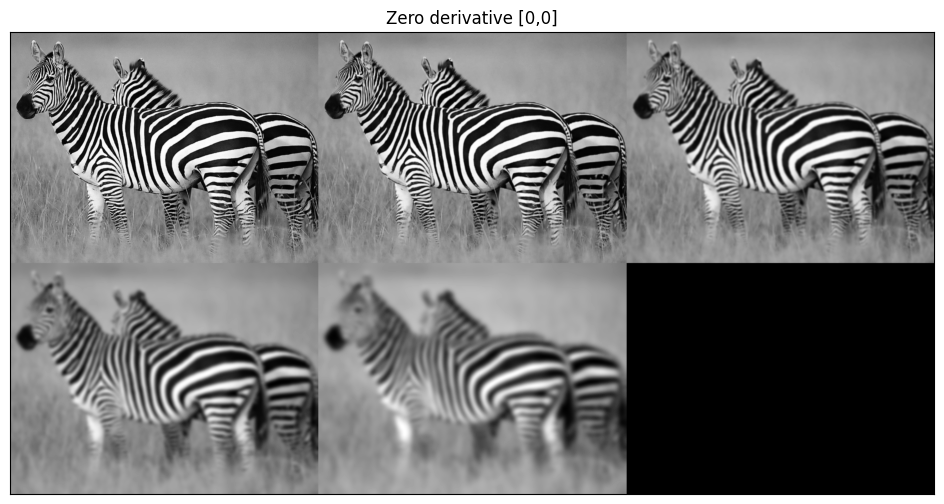

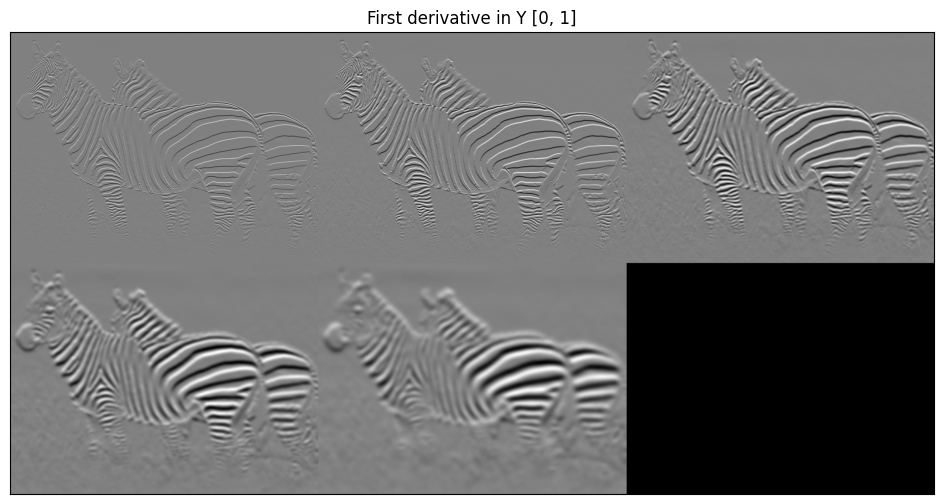

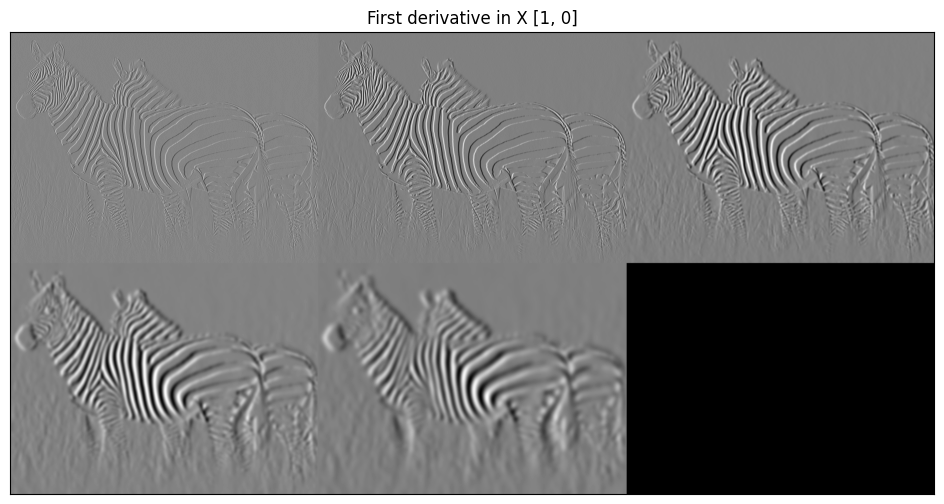

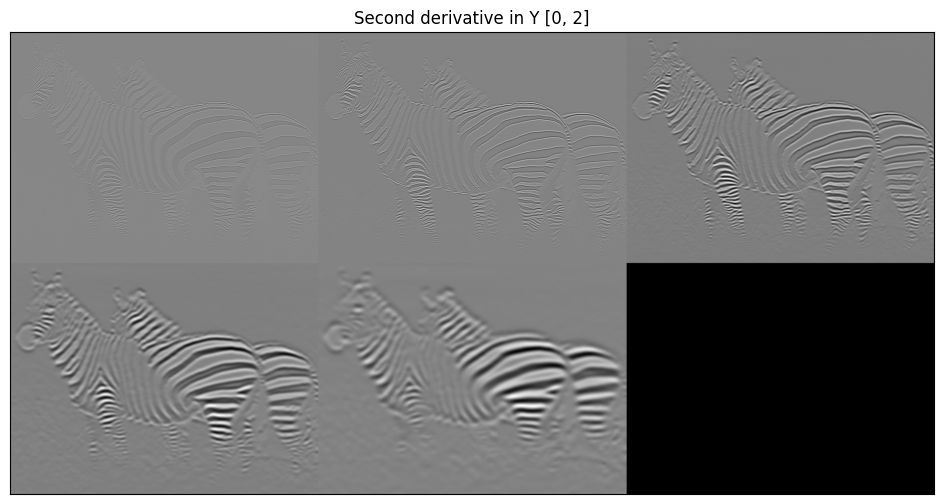

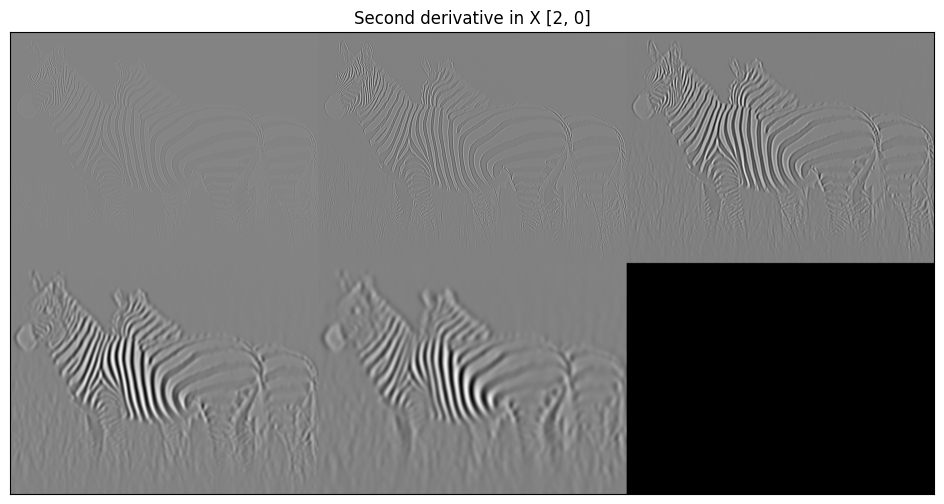

In [ ]:
'''
This function performs 2D convolution on an image with Gaussian and derivative masks.
'''
def my2DConv(im, sigma, orders):
  ddepth=cv2.CV_64F # For visualization purposes
  maskG,_=gaussianMask1D(sigma, order=0) # Calculate 1D Gaussian mask
  maskDG,_=gaussianMask1D(sigma, order=1) # Calculate 1st order derivative
  mask2DG,_= gaussianMask1D(sigma, order=2) # Calculate 2nd order derivative
  if orders==[0,0]: # Gaussian smoothing
    # Smooth in both directions
    return cv2.sepFilter2D(im,ddepth,maskG,maskG)
  elif orders==[1,0]: # First derivative in X
    # Smooth in Y direction, differentiate in X direction
    return cv2.sepFilter2D(im,ddepth,maskDG,maskG)
    # and MaskG as vertical 1D Gaussian kernel.
  elif orders==[0,1]: # First derivative in Y
    # Smooth in X direction, differentiate in Y direction
    return cv2.sepFilter2D(im, ddepth, maskG, maskDG)
  elif orders == [2, 0]: # Second derivative in X
    # Smooth in Y direction, differentiate twice in X direction
    return cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
  elif orders == [0, 2]: # Second derivative in Y
    # Smooth in X direction, differentiate twice in Y direction
    return cv2.sepFilter2D(im, ddepth, maskG, mask2DG)
  else:
    print('error in order of derivative')

# Let's check the function
im=cv2.imread(get_image('zebra.jpg'),0).astype(np.float64) # working in a greyscale
# Float to avoid precision problems and truncation of integer values
vim0=[]
orders=[0,0]
for sigma in [0.75,2,5,10,15]: # Gaussian smoothing for different sigmas
  vim0.append(rangeDisplay01(my2DConv(im,sigma,orders),True)) # Apply 2D convolution with zero-order Gaussian kernel in both directions and visualize it
displayMI_ES(vim0,'Zero derivative [0,0]',2) # Display the results

## For other orders:
# List to store results for orders and different sigmas
vim1 = []
# Orders of derivatives to compute
orders_list = [[0, 1], [1, 0], [0, 2], [2, 0]]
for orders in orders_list:
    vim_orders = []
    for sigma in [0.75, 2, 5, 10, 15]:
        vim_orders.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
        # I apply 2D convolution with specified orders of derivatives and sigma
        # and visualize the result, scaling it to [0, 1] range
    vim1.append(vim_orders)

# Display results for orders [0, 1], [1, 0], [2, 0], [0, 2]
titles = ['First derivative in Y [0, 1]', 'First derivative in X [1, 0]',
          'Second derivative in Y [0, 2]', 'Second derivative in X [2, 0]']
for i in range(len(vim1)):
    displayMI_ES(vim1[i], titles[i], 2)


## C) (1 point)

**The Task:** Use the OpenCV function `sepFilter2D()` and $\sigma=3.0$ to calculate the gradient (4 images: $X$ derivative, $Y$ derivative, magnitude and orientation) and the Laplacian of Gaussian.

**The Solution:** Here, I explain the theory about computing the LoG, gradient of an image, magnitude and orientation using OpenCV functions, particularly `sepFilter2D()`.

### **Gradient Calculation**

The gradient of an image can be computed two ways:
1. By using the Sobel operator, which calculates the first derivatives of the image in the X and Y directions.
2. By using Gaussian masks, with their first and second derivatives.

The magnitude and orientation of the gradient are derived from these derivatives. In this case, I will use second method and detect edges with Gaussian masks.

**Steps:**
- **First Derivative in X Direction (Gx):**
  I use my2DConv function with sigma of 3.0 and orders parameter [1, 0], to compute the first derivative in the X direction. These operation correspond to computing the gradient in the horizontal direction, which is similar to what the Sobel operator does.
- **First Derivative in Y Direction (Gy):**
  Similar to Gx, but computes the first derivative in the Y direction.
- **Gradient Magnitude (Gmag):**
  Calculated as the square root of the sum of squares of Gx and Gy, representing the overall intensity change at each pixel.
- **Gradient Orientation (Gdir):**
  Calculated using the arctan2 function to determine the angle of the gradient vector with respect to the horizontal axis.

The script employs separable convolution operations to efficiently compute the derivatives. Gaussian smoothing is implemented to reduce noise before derivative computation and increase the accuracy of gradient estimation.

### **Laplacian of Gaussian (LoG)**

LoG is useful for edge detection and feature extraction. It is calculated as the sum of two-dimensional convolutions of the image with a Gaussian kernel and the Laplacian operator. Mathematically, this operation can be expressed as:

   $$ \frac{d^2(I*G)}{dx^2} + \frac{d^2(I*G)}{dy^2} = I * (\frac{d^2G}{dx^2} + \frac{d^2G}{dy^2}) = I * \frac{d^2G}{dx^2} + I * \frac{d^2G}{dy^2}$$

It means that the operation can be broken down into a series of one-dimensional convolutions, making the computation more efficient compared to a single two-dimensional convolution. The Gaussian kernel smooths the image, while the Laplacian highlights intensity variations.

Here, the LoG is calculated by performing two separate convolutions:
1. Convolution by rows with the second derivative of the Gaussian.
2. Convolution by columns with the Gaussian, and then convolving by rows with the second derivative of the Gaussian.

**Steps:**
  - The my2DConv function is applied with a sigma of 3.0 and [2, 0] orders, indicating the computation of the second derivative in the X direction after Gaussian smoothing.
  - The resulting image represents the LoG of the input image.

The LoG is computed by applying separable convolutions with Gaussian smoothing followed by the second derivative computation in the X direction.
The resulting image highlights edges and features no matter of their orientation. As the Gaussian Mask is already scaled by sigma and sigma^2, there is no need to scale results this time.

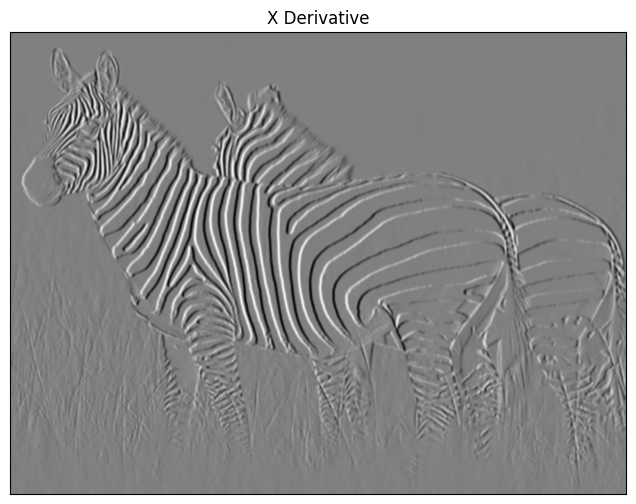

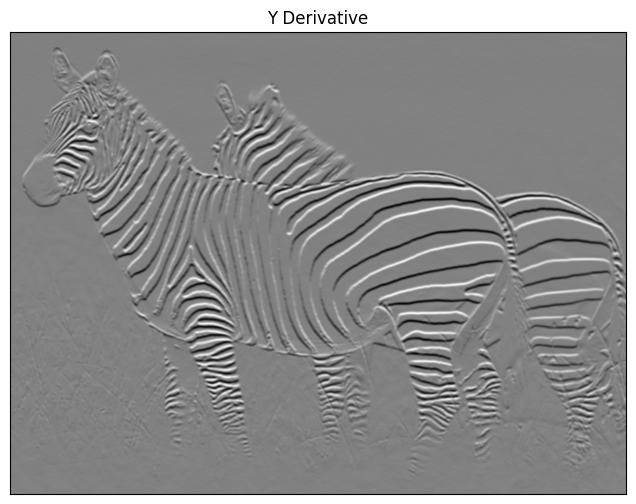

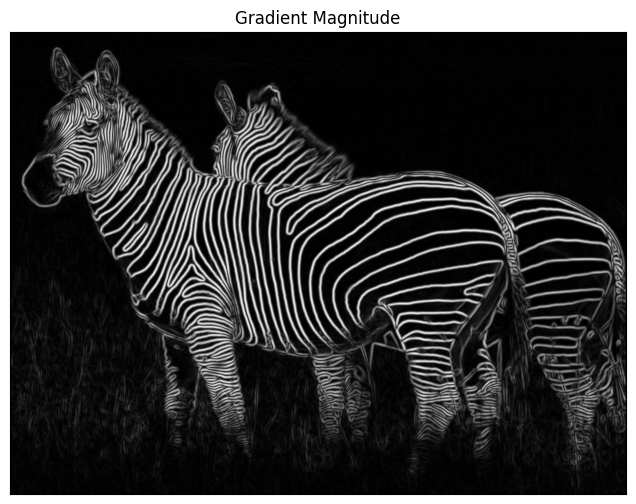

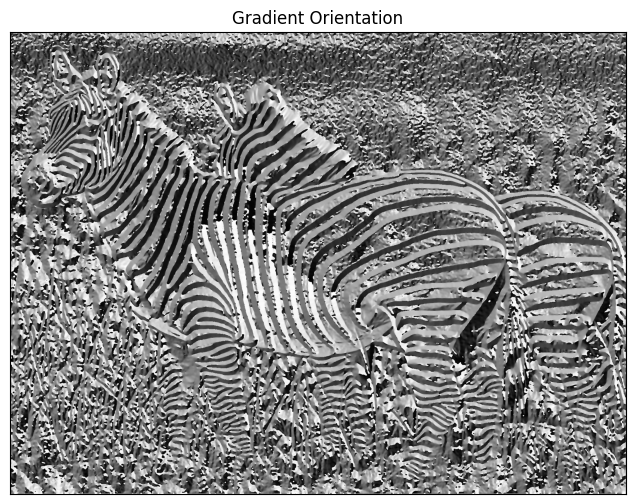

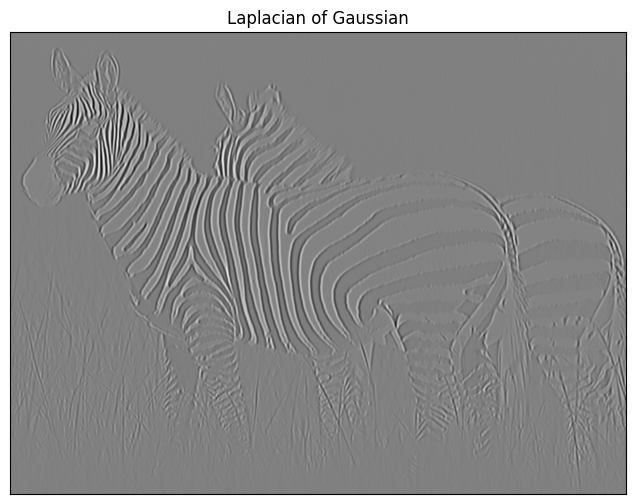

In [ ]:
'''
This script computes the first derivatives of an image in the X and Y directions,
the magnitude and orientation of the gradient, and the Laplacian of Gaussian (LoG).

The input image 'im' is loaded from 1.B.

Steps:
1. Compute the first derivative of the image in the X direction (Gx) using the my2DConv function.
2. Compute the first derivative of the image in the Y direction (Gy) using the my2DConv function.
3. Compute the magnitude of the gradient (Gmag) as the square root of the sum of squares of Gx and Gy.
4. Compute the orientation of the gradient (Gdir) using the arctan2 function.
5. Compute the Laplacian of Gaussian (LoG) by convolving the image with a Gaussian kernel
and then computing the second derivative in the X direction. It is computed with a sigma value of 3.0
6. Display the resulting images: X Derivative, Y Derivative, Gradient Magnitude, Gradient Orientation, and Laplacian of Gaussian.
'''

# Use image 'im' from 1.B.
sigma = 3.0

Gx = my2DConv(im, sigma, [1, 0]) # First derivative in X direction
Gy = my2DConv(im, sigma, [0, 1]) # First derivative in Y direction
Gmag = rangeDisplay01(np.sqrt(Gx**2 + Gy**2),True) # The magnitude of the gradient
Gdir = rangeDisplay01(np.arctan2(Gy, Gx),True) # The orientation of the gradient

# Laplacian of Gaussian
LoG = LoG = my2DConv(im, 3.0, [2, 0]) + my2DConv(im, 3.0, [0, 2]) # Calculated as second derivative in X direction after Gaussian smoothing

# Display the resulting images
displayIm(Gx, 'X Derivative')
displayIm(Gy, 'Y Derivative')
displayIm(Gmag, 'Gradient Magnitude')
displayIm(Gdir, 'Gradient Orientation')
displayIm(LoG, 'Laplacian of Gaussian')

# **Exercise 2**:  Gaussian and Laplacian pyramids (3 points)







## A) (1.5 points)

**The Task:** Build a 4-level Gaussian pyramid using $7\times7$ size Gaussian masks. Using the OpenCV `pyrUp()` and `pyrDown()` functions is not allowed.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Apples Pyramid')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

**The Solution:** In this part, I will provide details about Gaussian Pyramid Construction and theoretical reasoning behinds each steps.

Sometimes, we need to work with
an image at different resolutions:
- When we don't know the size of the object on the image we're looking for
- When we need to access an image with
different levels of blur.
In this cases, we can use Gaussian Pyramid.

### **Gaussian Pyramid**

The Gaussian pyramid is a multi-scale representation of an image, where each level in the pyramid contains a progressively downsampled version of the original image. This pyramid is constructed by applying Gaussian blur and downsampling operations iteratively.

**Steps:**
  
  For each level in the pyramid, except the original image, I'm performing the following steps:

  - **Gaussian Blur:**
      - First, I apply the Gaussian blur to the previous level using a 2D convolution operation. The sizeMask default size is 7x7.
      - The sigma for Gaussian mask is calculated based on the mask size T with the formula, mentioned before:
$$\sigma = \frac{T - 1}{6}$$
  - **Subsampling:**
      - Subsample the blurred image by downsampling it by a factor of 2, creating a lower-resolution version. Here, I tried 2 different approaches, one with cv2.resize and another with straightforward downsampling and experimentally chose second one.
      - Append the subsampled image to the Gaussian pyramid.

After this steps, I return the completed Gaussian pyramid, containing multiple levels of progressively downsampled images.

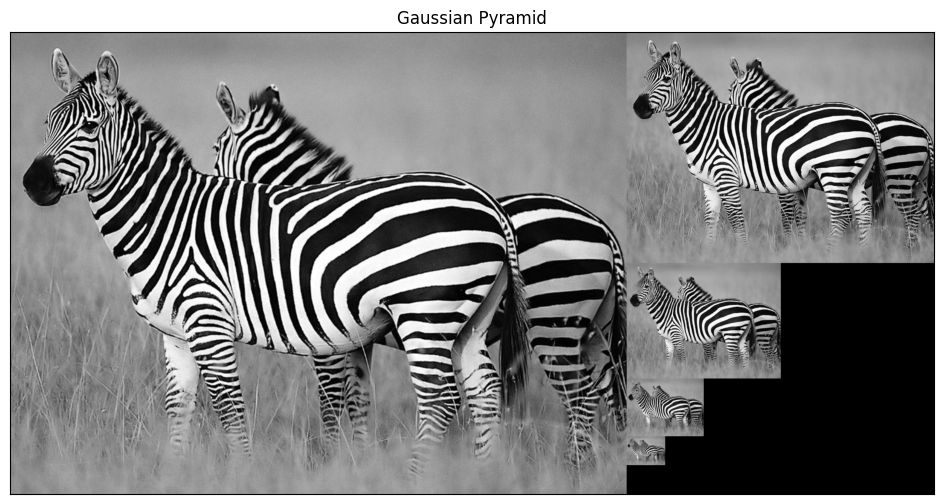

In [ ]:
'''
This function build a Gaussian pyramid of the input image.
'''

def pyramidGauss(im,sizeMask=7,nlevel=4):
  vim=[im]
  for _ in range(1, nlevel): # Building the pyramid
      sigma = (sizeMask - 1) / 6  # Compute sigma for Gaussian blur for the 2DConv function
      # Apply Gaussian blur to the previous level to get blurred image
      blurred = my2DConv(vim[-1], sigma=sigma, orders=[0,0])
      # Subsample the blurred image
      im_subsampled = blurred[::2, ::2]  # Downsampling by a factor of 2
      # im_subsampled = cv2.resize(blurred,(blurred.shape[1]//2,blurred.shape[0]//2),cv2.INTER_LINEAR) # 2nd option for downsampling
      # Append the subsampled image to the pyramid
      vim.append(im_subsampled)
  return vim

im=cv2.imread(get_image('zebra.jpg'),0).astype(np.float64) # Float type for the high precision
# Build the Gaussian pyramid
pyrG = pyramidGauss(im,sizeMask=7, nlevel=5) # 4 levels + original image
# Display the result
displayPyramid(pyrG,'Gaussian Pyramid')

## B) (1 point)

**The Task:** Use your code from the previous section to implement a function that allows you to build a 4-level Laplacian pyramid.

**The Solution:** Here I explain the steps performed to build 4-level Laplacian pyramid and the theory behind it.

### **Building a Laplacian Pyramid**

The Laplacian pyramid is a multi-scale image representation that captures the details, high-frequency components, of an image at different resolutions. It is constructed by calculating a series of levels, each containing information about the difference between levels of a Gaussian pyramid.

- **Gaussian Pyramid Construction:**
Gaussian smoothing and downsampling operations help in reducing noise and retaining essential image features at different resolutions.
   - The Gaussian pyramid is constructed using the `pyramidGauss` function, developed before. It is built by repeatedly applying Gaussian smoothing and downsampling operations, resulting in a series of images with progressively reduced resolution.

- **Laplacian Computation:**
The Laplacian operation highlights the differences or details between successive levels of the Gaussian pyramid, providing a compact representation of the image's structure.
   - The Laplacian pyramid is computed as the difference between each level of the Gaussian pyramid and the upsampled version of the next level.
   - This difference is calculated using the `cv2.subtract` function, which subtracts corresponding pixel values from the current level and the upsampled next level.
   - The resulting images in the Laplacian pyramid represent the high-frequency components of the image at different resolutions. These details can be used for reconstructing the original image.

- **Upsampling and Subtraction:**
   - To compute the Laplacian at each level, the next level of the Gaussian pyramid is upsampled to match the size of the current level with the `cv2.resize` function.
   - The upsampled image is then subtracted from the current level of the Gaussian pyramid, resulting in the Laplacian image for that level.

- **Final Laplacian Pyramid:**
   - The Laplacian images obtained from each level, are stored in a list to form the Laplacian pyramid, except the last level of the Gaussian pyramid.
   - The last level of the Gaussian pyramid is directly appended to the Laplacian pyramid, as there is no next level to compute its Laplacian.

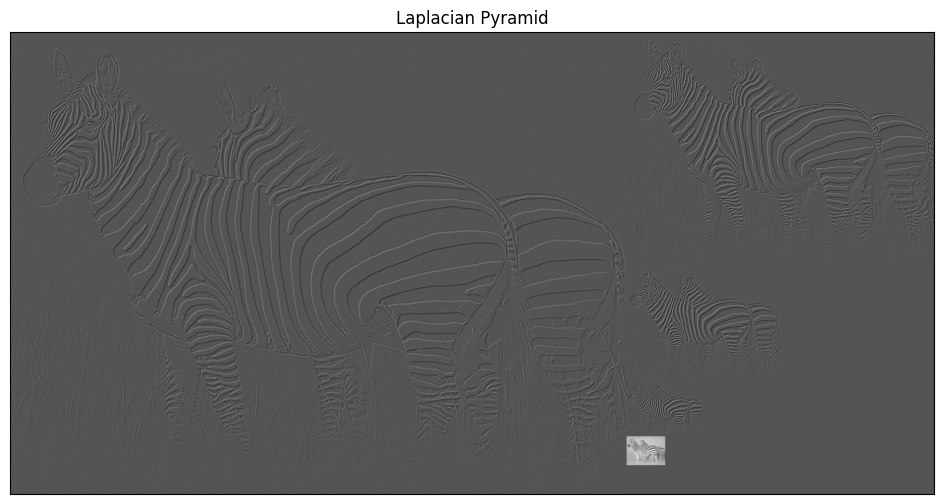

In [ ]:
'''
This function constructs a Laplacian pyramid from an input image using Gaussian pyramid decomposition.
The Laplacian pyramid represents the difference between each level of the Gaussian pyramid and the upsampled version of the next level.
It consists of the details (high-frequency components) of the image at different resolutions.
'''
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR):
    vim=pyrG=pyramidGauss(im,sizeMask=sizeMask, nlevel=nlevel) # Building Gaussian pyramid
    vimL=[]
    for i in range(nlevel-1): # Iterating through each level of the Gaussian pyramid
        # Upsampling the next level of the Gaussian pyramid
        upsampled = cv2.resize(vim[i+1], (vim[i].shape[1], vim[i].shape[0]), interpolation=flagInterp)
        # Computing the Laplacian by subtracting the upsampled image from the current level
        laplacian = cv2.subtract(vim[i], upsampled, dtype=cv2.CV_32F)
        # Appending the Laplacian
        vimL.append(laplacian)
    vimL.append(vim[-1])  # The last level of Laplacian pyramid is the same as the last level of Gaussian
    return vimL

im=cv2.imread(get_image('zebra.jpg'),0).astype(np.float64) # Float type for precision
# Build the Laplacian pyramid
pyrL = pyramidLap(im,sizeMask=7, nlevel=5) # 4 levels + last level, the same as Gaussian
# Display the result
displayPyramid(pyrL,'Laplacian Pyramid')

## C) (0.5 points)

**The Task:** Now implement a function to reconstruct the image encoded/stored in the Laplacian pyramid. Verify that it is possible to obtain an exact copy of the original image. To do this, calculate the reconstruction error as the Euclidean norm of the differences between the intensity levels of the original image and the reconstructed image.

**The Solution:** In this section, I describe steps performed for image reconstruction with Laplacian pyramid.

### **Reconstructing an Image from a Laplacian Pyramid**

To reconstruct an image from its Laplacian pyramid, we need to expand each level of the pyramid to match the size of the next level and then add it to the corresponding level of the pyramid.

**Steps:**

- **Reconstruction:**
   - Starting from the finest level (the last level of the Laplacian pyramid), it iterates through each level in reverse order, except for the last level.
   - For each level, the Laplacian image is expanded to match the size of the next level with the `cv2.resize` function, the interpolation method is `flagInterp=cv2.INTER_LINEAR`.
   - It adds the expanded image to the Laplacian image of the next level with the `cv2.add` function. As a result we get the reconstructed image for that level.
   - Then it appends the reconstructed image for each level to the `reconstruction_steps` list.
   - At the end, the function returns the final reconstructed image and the list of reconstruction steps.

- **Error Calculation:**
   - After the reconstruction process, the function calculates the reconstruction error. It is computed as the Euclidean norm of the differences between the intensity levels of the original image `im` and the final reconstructed image `reconstructed_image`.

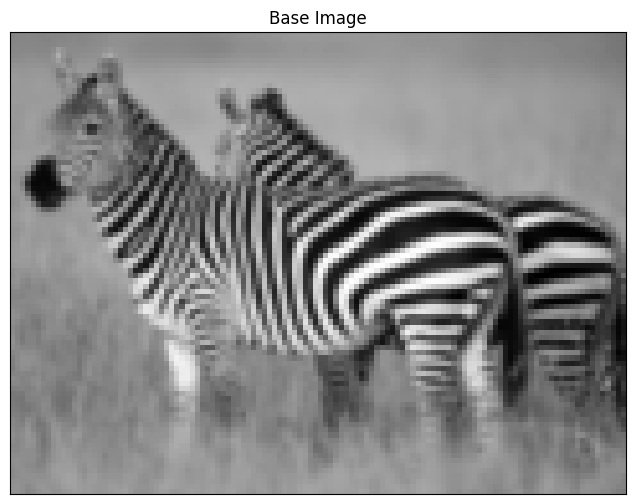

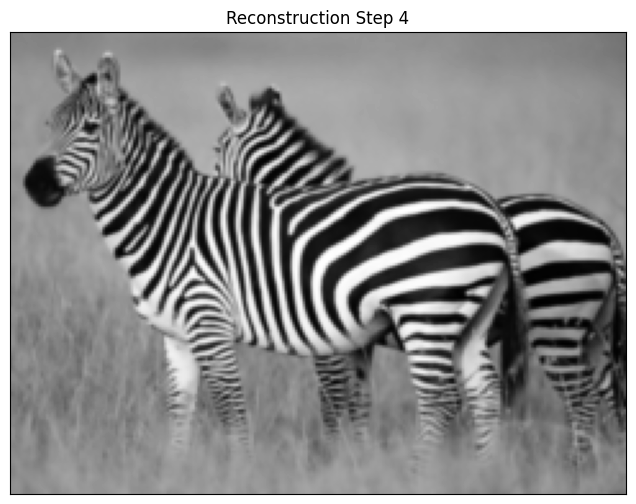

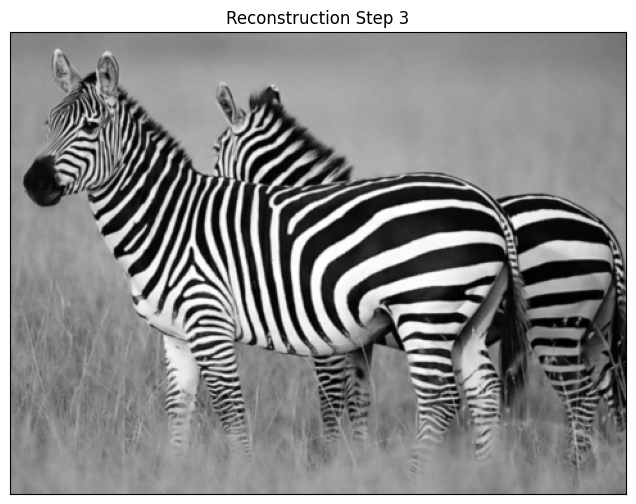

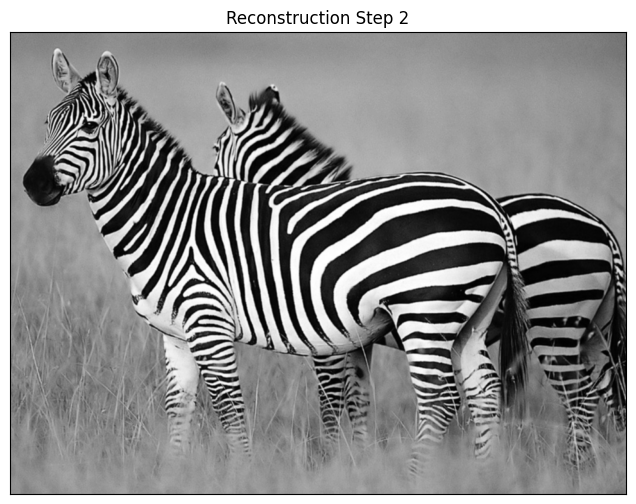

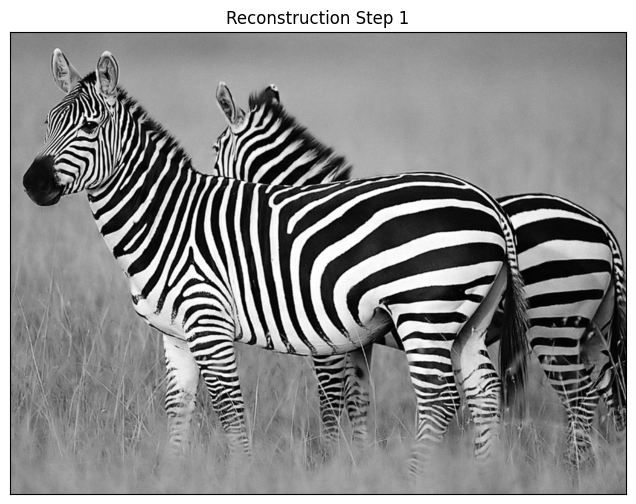

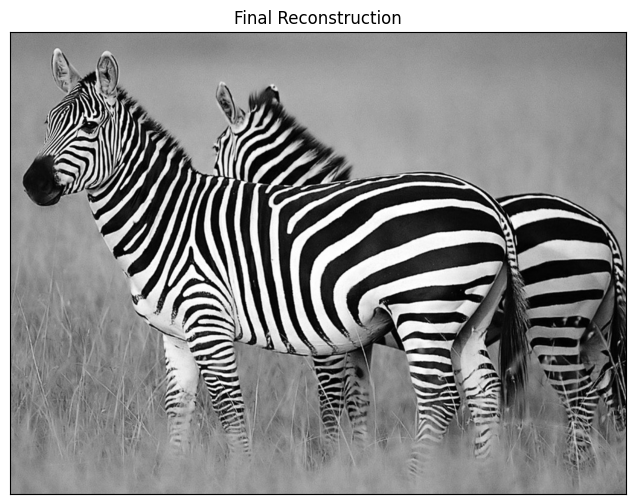

Error per pixel: 0.0


In [ ]:
'''
This function reconstructs the original image from the Laplacian pyramid.
It expands each level of the pyramid to match the size of the next level and then adds it to the corresponding level of the pyramid.
'''

def reconstructLap(pyL, flagInterp=cv2.INTER_LINEAR):
    reconstruction_steps = []  # List to store each reconstruction step
    current_level = pyL[-1] # Take last level of the Laplacian pyramid as a starting point
    reconstruction_steps.append(current_level)  # Add the starting level to the steps

    for level in reversed(pyL[:-1]):
        # Expand the current image to the next level's size
        expanded = cv2.resize(current_level, (level.shape[1], level.shape[0]), interpolation=flagInterp)
        # Add the expanded image to the current level of the Laplacian pyramid
        current_level = cv2.add(expanded, level, dtype=cv2.CV_32F)
        # Store the current reconstruction step
        reconstruction_steps.append(current_level)

    # Reverse the list so that it starts with the best level reconstruction
    reconstruction_steps.reverse()
    return current_level, reconstruction_steps

im = cv2.imread(get_image('zebra.jpg'), 0).astype(np.float64)  # Float for precise calculations
# Build the Laplacian pyramid
pyrL = pyramidLap(im, sizeMask=7, nlevel=4 + 1)
# Apply function to calculate the reconstruction steps
reconstructed_image, reconstruction_steps = reconstructLap(pyrL, flagInterp=cv2.INTER_LINEAR)

# Display each level of the reconstruction process in reverse order, labeling step 5 as "Base Image"
for i, step in enumerate(reversed(reconstruction_steps)):
    if i == 0:
        # For the first step in reverse order (which is actually the last step)
        title = 'Base Image'
    else:
        title = f'Reconstruction Step {len(reconstruction_steps) - i}'
    displayIm(step, title=title)

# Display the final reconstructed image
displayIm(reconstructed_image, "Final Reconstruction")
# Calculate and print the reconstruction error
error_per_pixel = np.sqrt(np.linalg.norm(im - np.round(reconstructed_image), ord=2) / np.prod(im.shape))
print('Error per pixel:', error_per_pixel)

# **Exercise 3: Hybrid Images** (2 points)

This exercise is inspired on the following paper: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$. (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf).  

**The Task:** The goal is to learn how the distance affects the human visual system when it extracts information about an object. To do this, we build a hybrid image from two images of different objects. By properly mixing part of the high frequencies of one image with part of the low frequencies of another image, we obtain a hybrid image whose perception differs with distance. The sigma used to filter both images (both high and low frequencies) is the key aspect to select the high and low frequency range of each image. The higher the sigma value, the greater the removal of high frequencies from the image. It is recommended to choose this value separately for each of the images and, in fact, it is possible (and even desirable) to have different values for different pairs of images. Remember to use the Gaussian pyramid to show the effect obtained.

In particular, the students are required to generate, at least, the hybrid images corresponding to Einstein-Marilyn, Cat-Dog, and Fish-Submarine, as shown below.

**The Solution:** In this section, I explain the foundaiton behind generation of hybrid images, which blend the high frequencies of one image with the low frequencies of another, to get an image that looks differently depending on the viewing distance.

### **Hybrid Image Generation**

- **High and Low Frequencies:** Images can be decomposed into high and low frequency components. High frequencies  are the ones with fine details and most accentuated edges in the image. Low frequencies, on the other hand, represent slow changes and correspond to the overall structure and general features of the image, they have a softer appearance.

- **Gaussian Filtering:** To get low frequencies we can use Gaussian masks which filter images. With different sigma values we can control the amount of smoothing applied. The higher the sigma value, the greater the
removal of high frequencies in the convolved
image. To get high frequencies, we can calculate the difference between the original and its smoothed version. By adjusting sigma, we can filter out high and low frequencies from the images. Sometimes it's better to choose sigma values for each of the two image separately.

- **Hybrid Image Generation:** We can create hybrid images by combining the high frequencies of one image with the low frequencies of another. It can be achieved by subtracting the low-pass filtered version of one image from the original image and adding it to the high-pass filtered version of the other image.

**Steps:**

- **Load Images:** Images for the hybrid image generation should consist objects that can be percieved a bit differently at varying distances.

- **Set Sigma Values:** Sigma values determine the amount of smoothing applied to the images and control the frequency content of each image. They are chosen to balance between high-frequency details and the emphasis on low-frequency components in each image pair. Lower sigma values (like 3, 4) are selected for images with intricate details, such as Einstein and Fish, to retain high-frequency information. Higher sigma values (like 8, 10) are chosen for images with smoother features, like Cat and Submarine, to emphasize low-frequency components. For Marylin I dicreased sigma value to balance Einstein detailing.

- **Generate Hybrid Images:** For each image pair, I use the `generateHybridImages` function to create a hybrid image. This function filters each image to extract high and low frequencies and then combines them to create the hybrid image:
  - Calculates Gaussian masks for each image based on the provided sigma values.
  - Smooths the images using the `sepFilter2D` function to extract low-frequency components.
  - Calculates high-frequency components by subtracting the low-pass filtered images from the original images.
  - Combines the low and high frequencies to create the hybrid image.

4. **Display Hybrid Images:** After applying calculated function to loaded images with setted sigma values, to check if the effect is achieved, I built the Gaussian pyramid with the hybrid images. In this case there is no need to move away from the computer to see the effect, which means that the task was solved successfully.

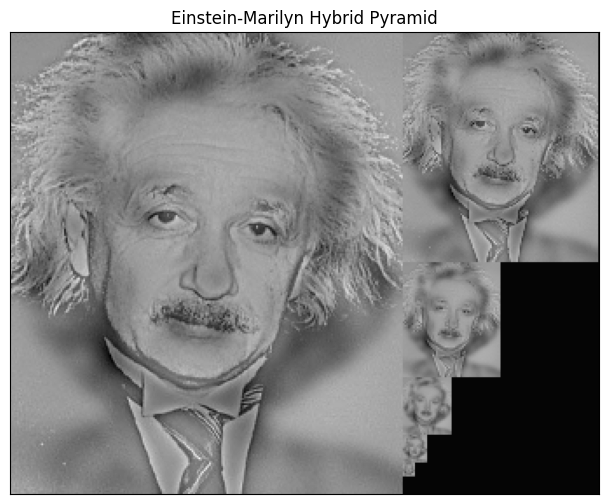

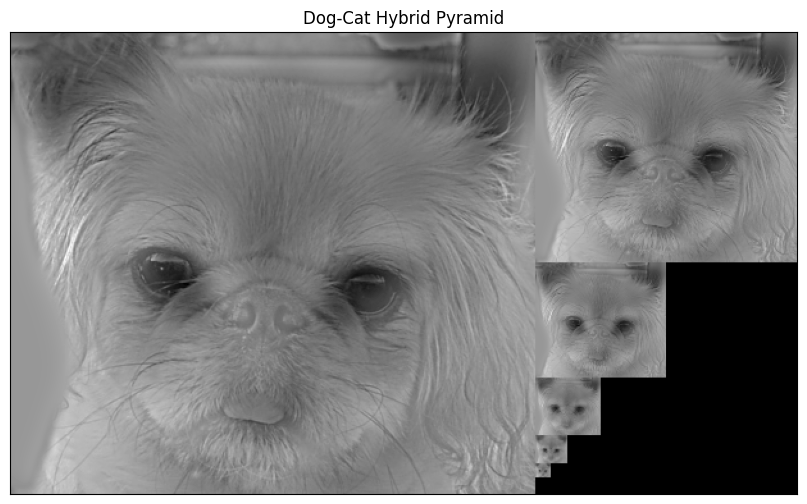

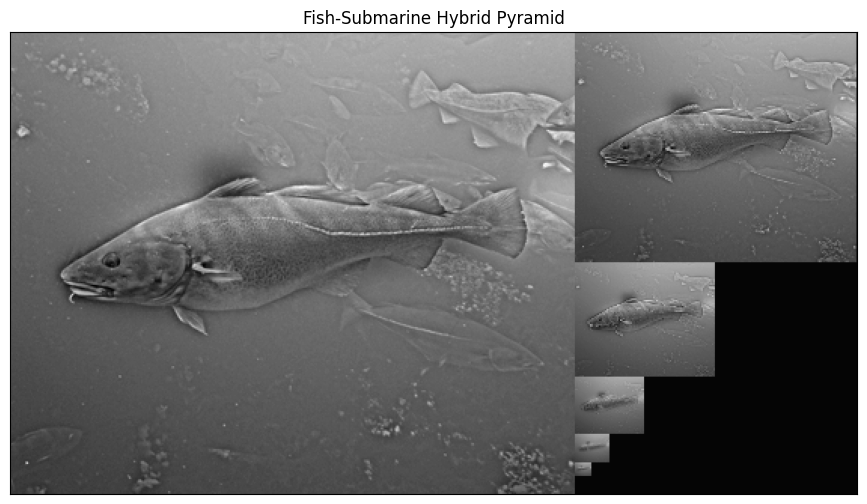

In [ ]:
'''
This function generates hybrid images by blending the high-frequency components of one image
with the low-frequency components of another image.
'''

# Function to generate hybrid image
def generateHybridImages(img1, img2, sigma1, sigma2):
    # Calculate Gaussian masks
    img1_mask,_ = gaussianMask1D(sigma=sigma1, sizeMask=0, order=0)
    img2_mask,_ = gaussianMask1D(sigma=sigma2, sizeMask=0, order=0)
    # Smooth the images to get low frequencies
    img1_low = cv2.sepFilter2D(img1, cv2.CV_64F, img1_mask, img1_mask)
    img2_low = cv2.sepFilter2D(img2, cv2.CV_64F, img2_mask, img2_mask)
    # Calculate high frequencies as the difference between original and low-pass filtered images
    img1_high = img1 - img1_low
    img2_high = img2 - img2_low
    # Combine the low and high frequencies to create the hybrid image
    hybrid_img = img1_high + img2_low
    return hybrid_img

# Load the images
einstein = cv2.imread(get_image('einstein.bmp'), 0)
marilyn = cv2.imread(get_image('marilyn.bmp'), 0)
cat = cv2.imread(get_image('cat.bmp'), 0)
dog = cv2.imread(get_image('dog.bmp'), 0)
fish = cv2.imread(get_image('fish.bmp'), 0)
submarine = cv2.imread(get_image('submarine.bmp'), 0)

# Set sigma values for each image pair
sigmas = { # Generaly, sigma values was chosen by trial and error, but there is some reasoning behind starting point for each pair
    ('einstein', 'marilyn'): (3, 5),
    ('dog', 'cat'): (4, 10),
    ('fish', 'submarine'): (3, 8)
}

# Generate and display hybrid images for each pair
for pair, (sigma1, sigma2) in sigmas.items():
    img1_name, img2_name = pair
    img1 = globals()[img1_name]
    img2 = globals()[img2_name]
    # Generate the hybrid image
    hybrid_img = generateHybridImages(img1, img2, sigma1, sigma2)
    # Display the Gaussian pyramid of the hybrid image
    images = [hybrid_img]
    for i in range(5):
        images.append(cv2.resize(images[-1], (images[-1].shape[1] // 2, images[-1].shape[0] // 2), interpolation=cv2.INTER_LINEAR))
    displayPyramid(images, title=f'{img1_name.capitalize()}-{img2_name.capitalize()} Hybrid Pyramid')

# **Exercise 4: Pyramid Blending** (1 point)

**Tha Task:** In this exercise you must create the merged image (horizontal) of the apple (`apple.jpg`) and the orange (`orange.jpg`) using the $\textit{Pyramid Blending}$ technique. It is recommended to use the OpenCV functions `pyrDown` and `pyrUp` (and explain its working/functioning). It is also essential to explain in detail the process followed when creating the new image (mixture of both), and the blending effect in the resulting image should be appropriate (like in the example displayed below).  



**The Solution:** Here I explain the steps performed for Pyramid Blending, including decomposing the images into Gaussian and Laplacian pyramids, blending corresponding levels of the Laplacian pyramids, and then reconstructing the final blended image.

### **Pyramid Blending**

- **Start:**
   - First, I converted images to floating-point type for precision.
   - Next, I initialized Gaussian pyramids for both the apple and orange images. These pyramids will help us decompose the images into different scales (levels of detail).

- **Gaussian Pyramids:**
   - To create the Gaussian pyramids, I'm downsampling image at each level by reducing its resolution by half with `pyrDown` function. This process captures the low-frequency components, blurry details, of the images.

- **Laplacian Pyramids:**
   - I initialize the Laplacian pyramids using the last level of the Gaussian pyramids. The highest level of the Laplacian pyramid corresponds to the original image.
   - For each level of the Gaussian pyramids, I'm performing the following steps:
       - Upsample the image to match the dimensions of the next lower level with the `pyrUp` function.
       - Subtract the upsampled version from the original level to obtain the Laplacian pyramid.
       - The Laplacian pyramid represents the high-frequency details (edges, textures) of the images.
   - This decomposition simplifies blending and isolates fine details.

- **Blending:**
   - To blend corresponding levels of the Laplacian pyramids I use horizontal mask. It plays a crucial role in determining how much of each image contributes to the final result. I assigned the upper part of the array with the size of the images to 1 and bottom part to 0.
   - Then element-wise multiplication is performed between the Laplacian coefficients and the mask, and added to the corresponding coefficients of the other image multiplied by (1 - mask).

- **Reconstructing the Blended Image:**
   - I'm obtaining the final blended image by reconstructing the blended Laplacian pyramid.
   - For this I upsample each level of the blended Laplacian pyramid to match the dimensions of the next higher level.
   - Then adding the upsampled coefficients to the corresponding coefficients of the next lower level gives to get the reconstructed image.
   - This way I obtain the final image, which contains both the low-frequency components from the Gaussian pyramid and the high-frequency details from the Laplacian pyramid.

- **Displaying results**
   - To ensure valid pixel values for display, we clip the resulting pixel values to the range [0, 255].
   - The final result is converted back to 8-bit format (uint8) for visualization.

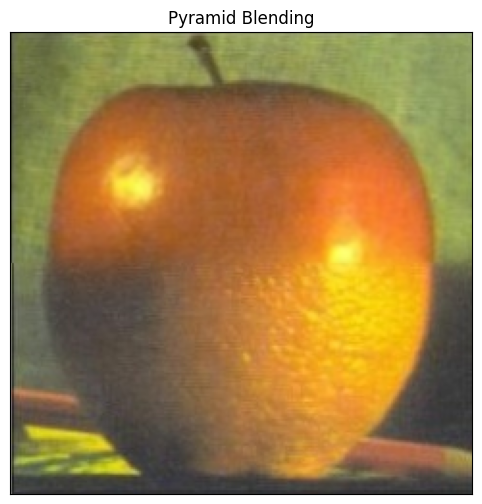

In [ ]:
'''
This function performes pyramid blending by calculating Laplacian pyramids of input images
and combining them with a Gaussian pyramid of a binary mask.
'''
def pyramidBlend(apple_img, orange_img, mask_img, levels=4):
    # Initialize lists to store Gaussian and Laplacian pyramids for apple, orange, and mask images
    apple_gauss = [apple_img.astype(float)]
    orange_gauss = [orange_img.astype(float)]
    mask_gauss = [mask_img.astype(float)]

    # Construct Gaussian pyramids by downsampling the images with pyrDown
    for _ in range(levels):
        apple_down = cv2.pyrDown(apple_gauss[-1])  # Downsample apple image
        orange_down = cv2.pyrDown(orange_gauss[-1])  # Downsample orange image
        mask_down = cv2.pyrDown(mask_gauss[-1])  # Downsample mask image
        apple_gauss.append(apple_down)  # Store downsampled apple image
        orange_gauss.append(orange_down)  # Store downsampled orange image
        mask_gauss.append(mask_down)  # Store downsampled mask image

    # Initialize Laplacian pyramids with the highest resolution levels
    apple_lap = [apple_gauss[-1]]
    orange_lap = [orange_gauss[-1]]

    # Build Laplacian pyramids by subtracting upsampled versions from original levels
    for i in range(levels, 0, -1):
        apple_up = cv2.pyrUp(apple_gauss[i], dstsize=apple_gauss[i-1].shape[1::-1])  # Upsample apple image
        orange_up = cv2.pyrUp(orange_gauss[i], dstsize=orange_gauss[i-1].shape[1::-1])  # Upsample orange image
        apple_lap_level = cv2.subtract(apple_gauss[i-1], apple_up)  # Compute Laplacian for apple
        orange_lap_level = cv2.subtract(orange_gauss[i-1], orange_up)  # Compute Laplacian for orange
        apple_lap.append(apple_lap_level)  # Store Laplacian for apple
        orange_lap.append(orange_lap_level)  # Store Laplacian for orange

    # Blend Laplacian levels using the mask
    blended_pyr = []
    mask_gauss_reversed = mask_gauss[::-1]
    for apple_lap, orange_lap, mask in zip(apple_lap, orange_lap, mask_gauss_reversed):
        blended_level = cv2.add(apple_lap * mask, orange_lap * (1.0 - mask))  # Weighted sum
        blended_pyr.append(blended_level)  # Store blended Laplacian level

    # Reconstruct the blended image by upsampling the blended Laplacian pyramid
    blended_image = blended_pyr[0]
    for i in range(1, len(blended_pyr)):
        expected_rows = blended_pyr[i].shape[0]
        expected_cols = blended_pyr[i].shape[1]
        blended_image = cv2.pyrUp(blended_image, dstsize=(expected_cols, expected_rows))
        blended_image = cv2.add(blended_image, blended_pyr[i])

    # Clip pixel values to the range [0, 255] and convert to uint8
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    return blended_image

# Load rhe imags and convert pixel values to float64 for percision
apple = cv2.imread(get_image('apple.jpg'), 1).astype(np.float64)
orange_image = cv2.imread(get_image('orange.jpg'), 1).astype(np.float64)
# Resize the apple image to match the dimensions of the orange image using linear interpolation
apple_image = cv2.resize(apple, (orange_image.shape[1], orange_image.shape[0]), interpolation=cv2.INTER_LINEAR)

# Create a grayscale mask, initialized with zeros, matching the dimensions of the orange image
mask_gray = np.zeros((orange_image.shape[0], orange_image.shape[1]), dtype=np.float64)
# Set the top half of the mask to white (1.0), creating a gradient effect
mask_gray[:mask_gray.shape[0] // 2, :] = 1.0
# Convert the grayscale mask to an RGB mask by stacking three identical channels with np.stack
mask_rgb = np.stack([mask_gray, mask_gray, mask_gray], axis=-1)

# Perform pyramid blending
pyramid_blending = pyramidBlend(apple_image, orange_image, mask_rgb)
# Convert the blended result from BGR to RGB color space
pyramid_blending_rgb = cv2.cvtColor(pyramid_blending, cv2.COLOR_BGR2RGB)

# Display the final blended image
displayIm(pyramid_blending_rgb, "Pyramid Blending")